In [6]:
import time
import datetime
import numpy as np
from datetime import datetime as dt
from tqdm import *
from datetime import datetime as dt
from tqdm import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
def cal_mae(label, pred):
    return np.sum(np.abs(label - pred)) / label.size

# 评价MAE
def cal_all_mae(label, pred):
    # 所有样本所有步总的mae
    all_mae = cal_mae(label, pred)
    mae_step = []
    for i in range(test_window):
        mae_step.append(cal_mae(label[:,i], pred[:,i]))
    mae_window = []
    for i in range(label.shape[0]):
        mae_window.append(cal_mae(label[i,:], pred[i,:]))
    
    return all_mae,mae_step,mae_window

def show_mae(label, pred):
    mae_all, mae_step, mae_window = cal_all_mae(label, pred)
    print('平均MAE：%s' % mae_all)
#     plt.plot(mae_step,label='each step MAE')
#     plt.legend()
#     plt.show()
#     plt.plot(mae_window, label='each sample MAE')
#     plt.legend()
#     plt.show()
    


# 展示图 

def plot_eachstep(label, pred, start, end):
    #展示
    for i in range(test_window):
        mylabel = label[start:end,i]
        
        mypred = pred[start:end,i]
        plt.figure(figsize=(20, 5))
        plt.plot(mylabel,label='label_%s' %i)
        plt.plot(mypred, label='pred_%s' % i)
#         plt.plot(mylabel_new, label='ref_%s' % i)
        plt.legend()
        plt.show()


In [7]:
# read_arma_044A02_result
path_arma = './arma_result/ARMA_20171118_20171119_10period_044A02.csv'
df_arma = pd.read_csv(path_arma)
df_arma = df_arma.set_index('Unnamed: 0')

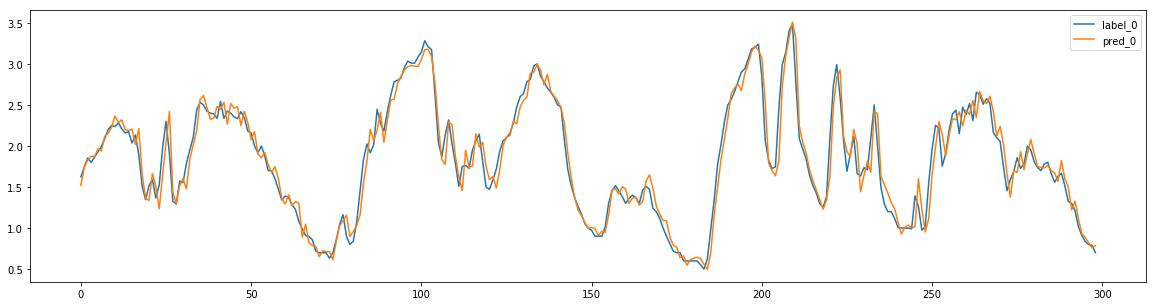

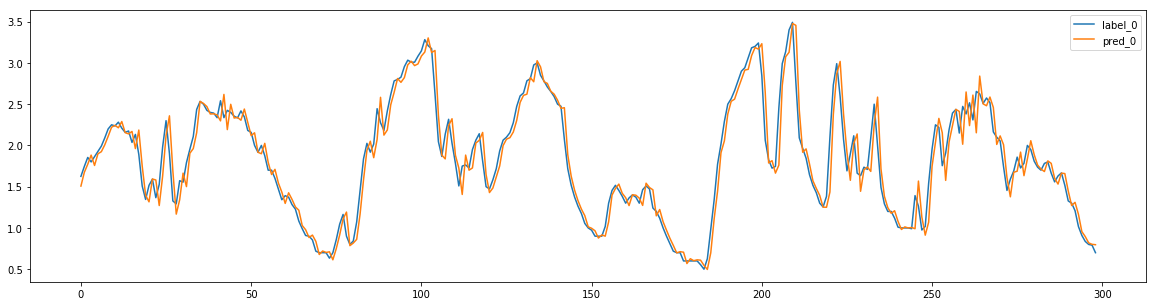

平均MAE：0.11893127289591907
平均MAE：0.13265906246862144


In [25]:
batch = -1
test_window = 1
train_step = 5 #用于确定arma模型从哪里开始能够对应上
start = 60
end = start + 300


path_prefix = './data/res/multi_step_lstm/res/'
label = np.fromfile('%s/label.bin' % path_prefix)
pred = np.fromfile('%s/logits.bin' % path_prefix)
label = label.reshape(batch,test_window)
pred = pred.reshape(batch,test_window)
raw_label, raw_pred = label, pred
label, pred = restore_diff(raw_label,raw_pred,valid_label,train_step)
data_arma = df_arma.values[:,0:test_window]


label = label[start:end]
pred = pred[start:end]
arma_pred = data_arma[start+train_step-1:end+train_step-1] #非常重要：这里需要减去1，因为test_window与train_window有一个重合step
plot_eachstep(label, pred, 0, -1)
plot_eachstep(label, arma_pred, 0, -1)
show_mae(label, pred)
show_mae(label, arma_pred)


In [1]:
import os,sys
sys.path.append('../xlib/src/')
sys.path.append('../xlib/src/expriment')
sys.path.append('../xlib/src/xtrainer/')
from dataprepare import *
from dataset_monitor import dataset_monitor_value_period
df, x_cols, y_cols, label_cols,label_restore_names = dataset_monitor_value_period()
_date = ['2017-10-30 00:00:00','2017-11-18 00:00:00','2017-11-18 00:00:00','2017-11-19 00:00:00','2017-11-18 00:00:00','2017-11-19 00:00:00']
dp = TimeWindowDataPrepare(df, x_cols, y_cols, label_cols[0], _date, normalize_features=False)
label =df[label_restore_names[0]].reset_index(level=0, drop=True)
train_start, train_end, valid_start, valid_end, test_start, test_end = [pd.Timestamp(d) for d in dp.date]
train_label = label.loc[train_start:train_end]
valid_label = label.loc[valid_start:valid_end]


Load rawdata from disk done. path=../xlib/src/xdata/../../data/gas_censor.pkl
eval feature done. start to transform to dataframe..
test_label Ref(StaticFeature(044A02),-1) ['SensorID', 'Time']
LABEL0 Ref(StaticFeature(044A02),-1) ['SensorID', 'Time']
LABEL_STORE Ref(StaticFeature(044A02),-1) ['SensorID', 'Time']


In [18]:
def restore_diff(label, logits, valid_data, train_step):
    """
    label:ndarray 输出的label，需要进行恢复 shape=[time, step_num]
    logits:ndarray 预测的值，需要进行恢复，shape同label
    valid_data:pd.DataFrame 实际的valid_data，恢复时需要使用的原始数据 shape=[time+train_step]
    注意：
    valid_data[train_step:]需要与label[:,0]相对应
    """
    train_step = train_step - 1 #train_step-1对应的位置才是真正开始预测的位置
    assert label.shape == logits.shape
    assert label.shape[1] < train_step # 需要保证预测长度短于训练长度啊
    # restore label
    restore_label = []
    real_label = valid_data[train_step:train_step+label.shape[0]]
    for i in range(label.shape[1]):
        restore_label.append(real_label.shift(-1*i).fillna(method='ffill').values.reshape((-1,1)))
    mylabel = np.concatenate(restore_label,axis=1)

    #restore logits
    restore_logits = []
    use_label = valid_data[train_step-1:train_step+logits.shape[0]-1].values.reshape((-1,1))
    mylogits = logits.copy()
    mylogits = use_label + np.cumsum(mylogits, axis=1)
    return mylabel, mylogits
rlabel, rpred = restore_diff(raw_label,raw_pred,valid_label,train_step)

In [5]:
# for t in dp.train_batch():
#     a = t
#     break
# feature_x, feature_y, label, pre_label = a
# label

In [4]:
# feature_x